In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

### 准备训练数据

In [2]:
# 处理数据,归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 手写数字数据集
train_dataset = torchvision.datasets.MNIST(
    'data', train=True, transform=transform, download=True)
# 数据集加载器
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True)

### 定义生成器
输入是长度为100的噪声(正态分布随机数)

输出为 (1, 28, 28) 的图片

linear 1: 100 -> 256

linear 2: 256 -> 512

linear 3: 512 -> 28 * 28

reshape: 28 * 28 -> (1, 28, 28)

In [3]:
class Generator(nn.Module):
    """
    生成器
    """

    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        # x 表示长度为100的noise输入,传入生成器网络生成
        img = self.main(x)
        img = img.view(-1, 28, 28, 1)
        return img

### 定义判别器

输入为(1, 28, 28)的图片

输出为二分类的概率值,使用sigmoid激活(0-1)

BCEloss计算交叉熵损失

In [4]:
class Discriminator(nn.Module):
    """
    判别器
    """

    def __init__(self):
        super(Discriminator, self).__init__()
        """
        nn.LeakyReLU() f(x) -> x > 0 输出 0 否则就输出 a * x a 是一个很小的数
        辨别器推荐使用 LeakyReLU()
        """
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.main(x)
        return x

### 初始化模型、优化器和损失函数

In [5]:
# 模型
gen = Generator()
gen.load_state_dict(torch.load('gan.pt'))
dis = Discriminator()
dis.load_state_dict(torch.load('dis.pt'))

# 优化器
g_optim = optim.Adam(gen.parameters(), lr=0.0001)
d_optim = optim.Adam(dis.parameters(), lr=0.0001)
# 损失函数
loss_fn = nn.BCELoss()


### 绘图方法

In [6]:
def gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((prediction[i] + 1) / 2)
        plt.axis('off')
    plt.show()

In [7]:
# 随机噪声,用于给生成器生成图片
test_input = torch.randn(16, 100)

### GAN训练

Epoch: 0


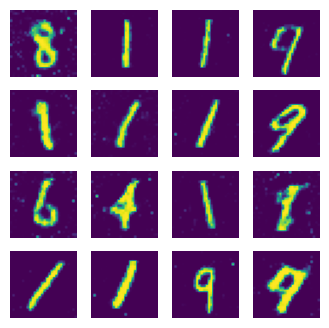

Epoch: 5


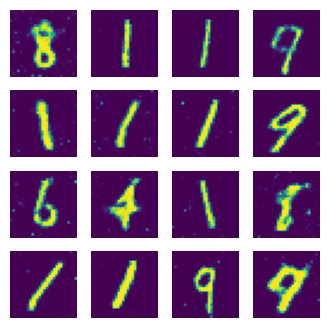

Epoch: 10


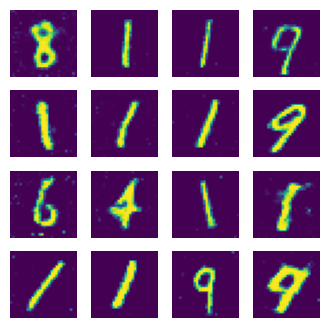

Epoch: 15


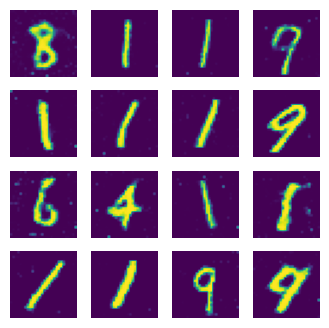

In [8]:
G_loss = []
D_loss = []

# 训练循环
for epoch in range(20):
    g_epoch_loss = 0
    d_epoch_loss = 0
    count = len(train_dataloader)
    for step, (img, _) in enumerate(train_dataloader):
        size = img.size(0)
        # 输入的噪音值,用于给生成器生成图片
        random_noise = torch.randn(size, 100)

        d_optim.zero_grad()
        # 判别器输入真实的图片,判别器输出的是对真实图片的预测结果
        real_output = dis(img)
        # 获取判别器在真实图像上的损失
        d_real_loss = loss_fn(real_output, torch.ones_like(real_output))
        # 反向传播
        d_real_loss.backward()

        gen_img = gen(random_noise)  # 生成器用噪音生成图片
        fake_output = dis(gen_img.detach())  # 判别器辨别图片
        # 获取判别器在生成图像上的损失
        d_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output))
        # 反向传播
        d_fake_loss.backward()
        d_loss = d_real_loss + d_fake_loss
        # 判别器更新权重
        d_optim.step()

        g_optim.zero_grad()
        fake_output = dis(gen_img)
        # 生成器的损失
        g_loss = loss_fn(fake_output, torch.ones_like(fake_output))
        # 反向传播
        g_loss.backward()
        # 生成器更新权重
        g_optim.step()

        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    with torch.no_grad():
        if epoch % 5 == 0:
            d_epoch_loss /= count
            g_epoch_loss /= count
            D_loss.append(d_epoch_loss)
            G_loss.append(g_epoch_loss)
            print(f'Epoch: {epoch}')
            gen_img_plot(gen, test_input)

# 保存模型
torch.save(gen.state_dict(), 'gan.pt')
torch.save(dis.state_dict(), 'dis.pt')
